# Select suitable MDL test: KVLCC2 **at** speed

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from mdldb.hdf5_file import Hdf5File
from rolldecayestimators.direct_estimator_cubic import EstimatorCubic,EstimatorQuadraticB
from sklearn.base import clone
from copy import deepcopy
from sklearn.metrics import mean_absolute_error

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay' and project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine, index_col='id')

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [5]:
df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp
id,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None


In [6]:
df_rolldecays[['date','ship_speed']]

,date,ship_speed
id,,
21337,2018-04-03,0.0
21338,2018-04-03,0.0
21339,2018-11-28,0.0
21340,2018-04-04,15.5


In [7]:
run_ids = [21340,]
df_rolldecays=df_rolldecays.loc[run_ids].copy()

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


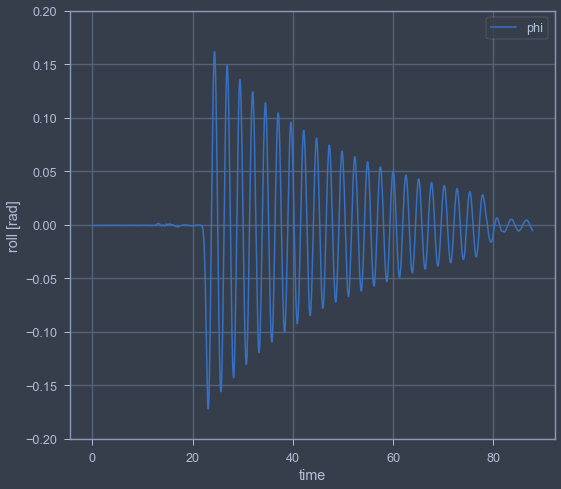

In [8]:
fig,axes=plt.subplots(nrows=len(df_rolldecays))
axes=[axes]

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.df.plot(y='phi', ax=ax)
    ax.set_ylabel(f"roll [{run.units['phi']}]")
    ax.grid(True)
    ax.set_ylim([-0.2,0.2])
    
plt.tight_layout()

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


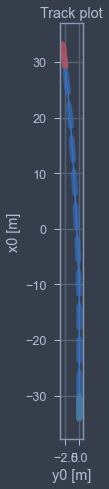

In [9]:
fig,axes=plt.subplots(ncols=len(df_rolldecays))
axes=[axes]
for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.track_plot(ax)
    
plt.tight_layout()

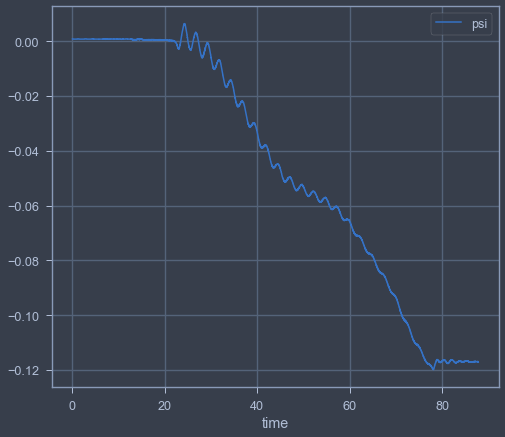

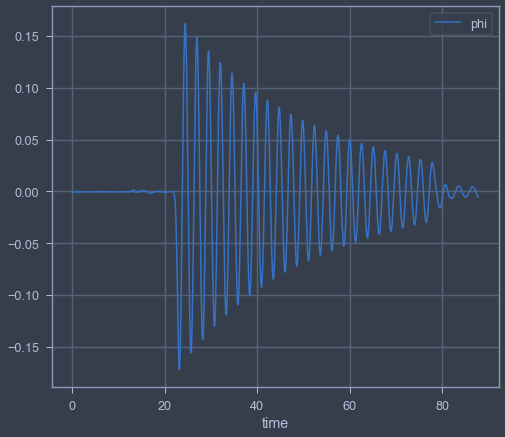

In [10]:
fig,ax=plt.subplots()
df = run.df.copy()
df['psi']=np.unwrap(df['modelpos/yawm'])

df.plot(y='psi', style='-', ax=ax)
ax.grid(True)

fig,ax=plt.subplots()
df.plot(y='phi', style='-', ax=ax)
ax.grid(True)

## Analyze the damping

In [70]:
#run = db.session.query(Run).get(21338)
#run = db.session.query(Run).get(21339)
run = db.session.query(Run).get(run_ids[0])

#run = db.session.query(Run).get(21340)

	
run = database.load_run(run, save_as_example=False, prefer_hdf5=True)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [71]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.999)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(2), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

## Offset?

In [77]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
]

pipline_preprocess_1 = Pipeline(steps=steps)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
]

pipline_preprocess_2 = Pipeline(steps=steps)

In [90]:
pipline_preprocess_1.fit(X=run.df)
X = pipline_preprocess_1.transform(X=run.df)

pipline_preprocess_2.fit(X=run.df)
X_trans = pipline_preprocess.transform(X=run.df)

<AxesSubplot:xlabel='time'>

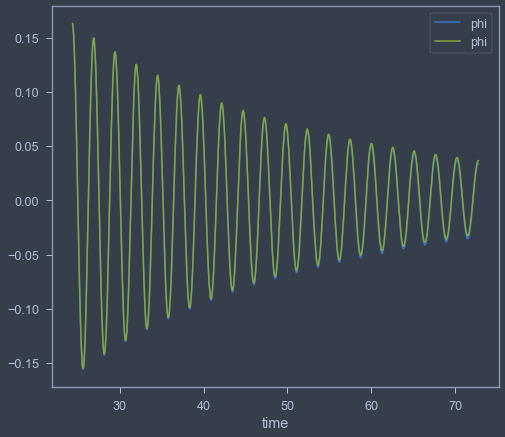

In [91]:
fig,ax=plt.subplots()
X.plot(y='phi', ax=ax)
X_trans.plot(y='phi', ax=ax)

In [92]:
estimator_cubic = EstimatorCubic(fit_method='derivation')
estimator_quadratic_b = EstimatorQuadraticB(fit_method='derivation', maxfev=1000)

In [93]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic)
]

pipline_cubic = Pipeline(steps=steps)

In [94]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_quadratic_b)
]

pipline_quadratic_b = Pipeline(steps=steps)

In [95]:
def calculate_score(pipeline,run):
    
    y_true =  pipeline['estimator'].X[['phi']]
    y_pred = pipeline.predict(X=run.df[['phi']])
    return np.rad2deg(mean_absolute_error(y_true=y_true, y_pred=y_pred['phi']))
    

In [99]:
models_cubic = OrderedDict()
scores = pd.DataFrame()

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    pipline_cubic.fit(X=run.df[['phi']])
    #scores.loc['models_cubic',id] = pipline_cubic.score(X=run.df[['phi']])
    scores.loc['models_cubic',id] = calculate_score(pipeline=pipline_cubic, run=run)

    
    models_cubic[id]=deepcopy(pipline_cubic)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


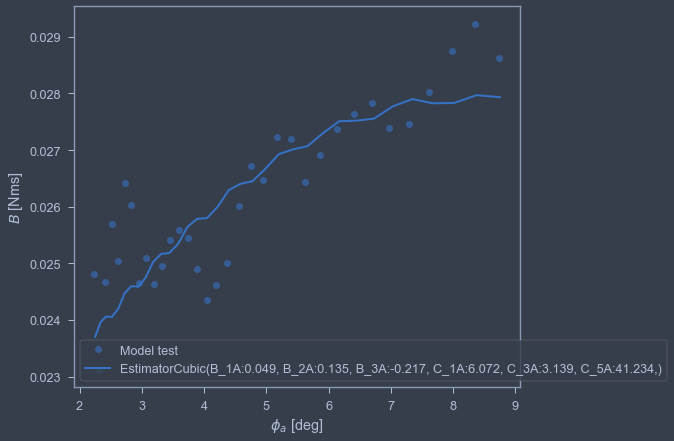

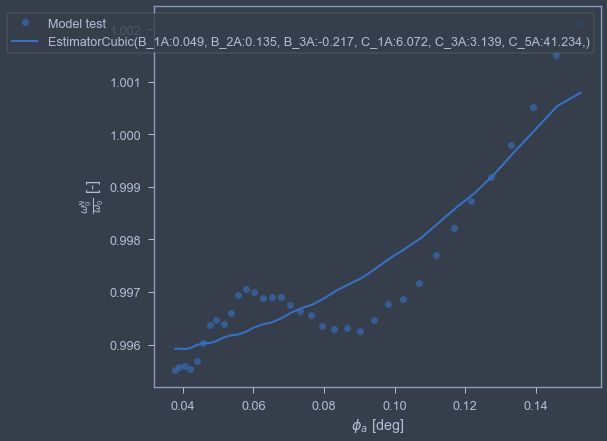

In [100]:
fig,ax=plt.subplots()

for id, model in models_cubic.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax)
    
fig,ax=plt.subplots()
for id, model in models_cubic.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=True)

## Quadratic

In [102]:
models_quadratic = OrderedDict()

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    pipline_quadratic_b.fit(X=run.df[['phi']])
    #scores.loc['pipline_quadratic_b',id] = pipline_quadratic_b.score(X=run.df[['phi']])
    scores.loc['pipline_quadratic_b',id] = calculate_score(pipeline=pipline_quadratic_b, run=run)
    
    models_quadratic[id]=deepcopy(pipline_quadratic_b)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


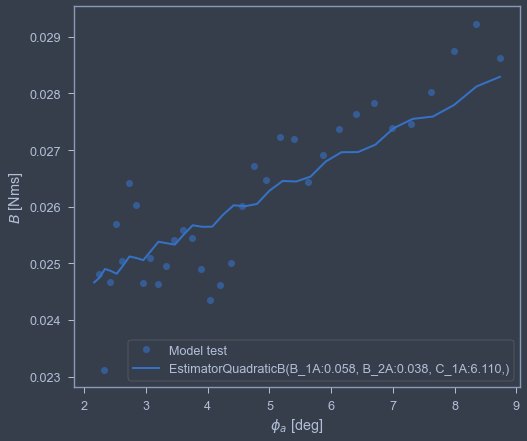

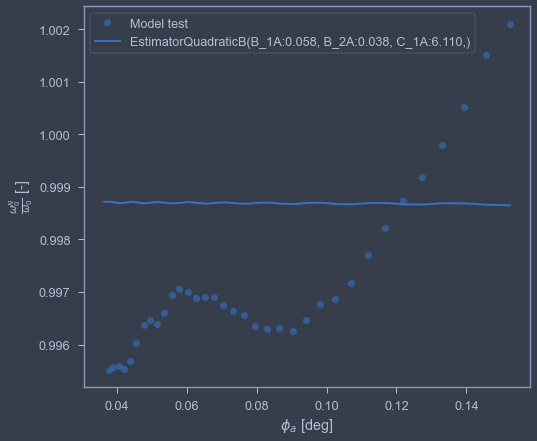

In [103]:
fig,ax=plt.subplots()

colors = ['r','g','b']
markers = ['o','*','+']

for id, model in models_quadratic.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax)
    
fig,ax=plt.subplots()
for id, model in models_quadratic.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=True)

## Integration


### Quadratic

In [134]:
estimator_quadratic_b_int = EstimatorQuadraticB(fit_method='integration', maxfev=100000, p0=estimator_quadratic_b.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_quadratic_b_int)
]

pipline_quadratic_b_int = Pipeline(steps=steps)

In [136]:
models_quadratic_b_int = OrderedDict()
np.random.seed(2)

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    pipline_quadratic_b_int.fit(X=run.df[['phi']])
    #scores.loc['pipline_quadratic_b_int',id] = pipline_quadratic_b_int.score(X=run.df[['phi']])
    scores.loc['pipline_quadratic_b_int',id] = calculate_score(pipeline=pipline_quadratic_b_int, run=run)
    
    models_quadratic_b_int[id]=deepcopy(pipline_quadratic_b_int)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


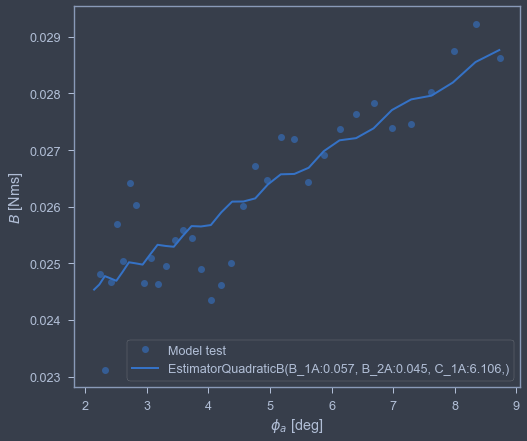

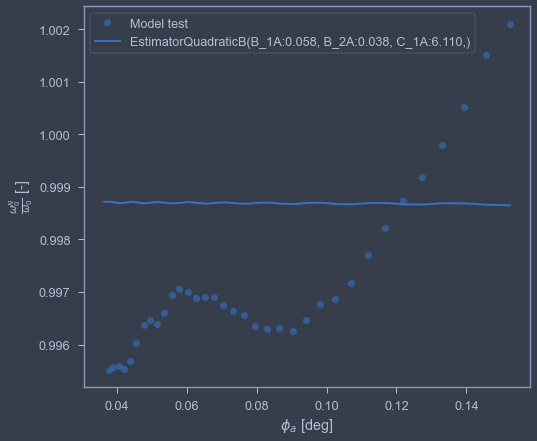

In [137]:
fig,ax=plt.subplots()

colors = ['r','g','b']
markers = ['o','*','+']

for id, model in models_quadratic_b_int.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax)
    
fig,ax=plt.subplots()
for id, model in models_quadratic.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=True)

### Cubic

In [138]:
estimator_cubic_int = EstimatorCubic(fit_method='integration', maxfev=100000, p0=estimator_cubic.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic_int)
]

pipline_cubic_int = Pipeline(steps=steps)

In [140]:
models_cubic_int = OrderedDict()
np.random.seed(3)

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    pipline_cubic_int.fit(X=run.df[['phi']])
    #scores.loc['models_cubic_int',id] = pipline_cubic_int.score(X=run.df[['phi']])
    scores.loc['models_cubic_int',id] = calculate_score(pipeline=pipline_cubic_int, run=run)
    
    
    models_cubic_int[id]=deepcopy(pipline_cubic_int)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


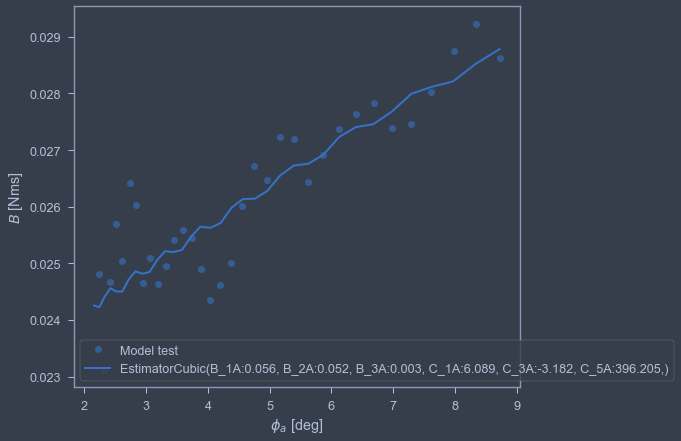

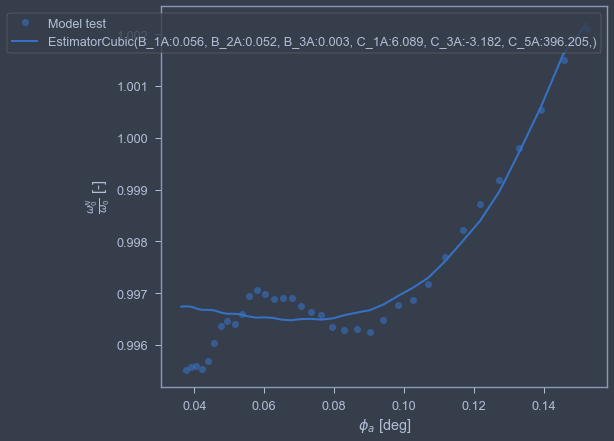

In [141]:
fig,ax=plt.subplots()

colors = ['r','g','b']
markers = ['o','*','+']

for id, model in models_cubic_int.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax)
    
fig,ax=plt.subplots()
for id, model in models_cubic_int.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=True)

In [142]:
scores.sort_values(by=run_ids, inplace=True)

Text(0, 0.5, 'MAE [deg]')

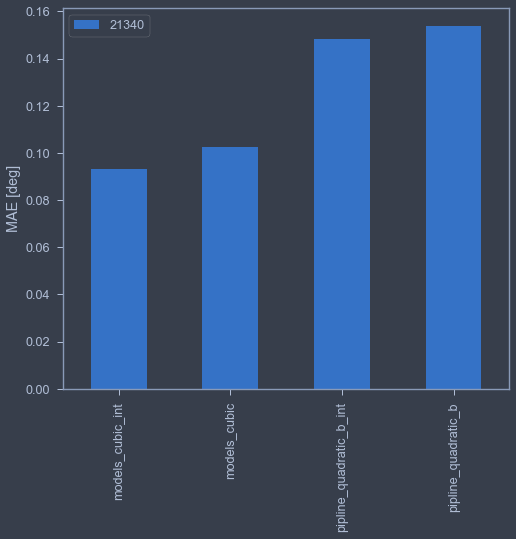

In [143]:
fig,ax=plt.subplots()
scores.plot(kind='bar', ax=ax)
ax.set_ylabel('MAE [deg]')

In [144]:
model = models_cubic_int[run_ids[0]]

In [145]:
scale_factor = run.model.scale_factor

meta_data = {
    'Volume':run.loading_condition.Volume/(scale_factor**3),
    'GM':run.loading_condition.gm/scale_factor,
}

estimator = model['estimator']
result_for_database = estimator.result_for_database(meta_data=meta_data)
result_for_database

{'C_3A': -3.182136165188061,
 'B_1A': 0.05572819045495379,
 'C_1A': 6.088581858717772,
 'B_2A': 0.05205936037135406,
 'C_5A': 396.2054109549698,
 'B_3A': 0.002887982347720985,
 'score': 0.9992140495309229,
 'phi_start': 0.16293739741722763,
 'phi_stop': 0.036667136224551956,
 'omega0_fft': 2.4755750032144674,
 'A_44': 135.000205443639,
 'C_3': -429.589036050022,
 'B_1': 7.52331716042100,
 'C_1': 821.959801787313,
 'B_2': 7.02802434539724,
 'C_5': 53487.8118768023,
 'B_3': 0.389878210259936,
 'omega0': 2.4675051891977393}

In [146]:
result_for_database['omega0']

2.4675051891977393

In [147]:
result_for_database['omega0']/np.sqrt(run.model.scale_factor)

0.2992289566712344

In [148]:
phi_a = np.deg2rad(10)

B_e = lambdas.B_e_lambda_cubic(B_1=result_for_database['B_1'],
                         B_2=result_for_database['B_2'],
                         B_3=result_for_database['B_3'],
                         omega0=result_for_database['omega0'],
                         phi_a = phi_a)

In [149]:
g=9.81
rho=1000
Volume = run.loading_condition.Volume/(scale_factor**3)
beam = run.ship.beam/scale_factor
lambdas.B_hat_lambda(B=B_e, Disp=Volume, beam=beam,g=g, rho=rho)

0.00292455872872454

## $A_{44}$

In [150]:
result_for_database['A_44']

135.000205443639

In [151]:
mass = run.loading_condition.Volume*rho
mass*run.loading_condition.KXX**2

168282350720.0

In [152]:
np.sqrt(result_for_database['A_44']/mass)

0.000657106729079211

In [153]:
result_for_database['A_44']/(mass*run.loading_condition.KXX**2)

8.022243857780537e-10

In [154]:
run.loading_condition.Volume/(run.ship.lpp*run.ship.beam*run.loading_condition.TA)

0.8098811546750663

In [155]:
run.ship.lpp

320.0

In [128]:
run.ship.beam

58.0

In [129]:
run.loading_condition.TA

20.8

In [130]:
equations.A44

GM*g*m/omega0**2

In [131]:
omega0 = result_for_database['omega0']
scale_factor = run.model.scale_factor
GM = run.loading_condition.gm/scale_factor
m = run.loading_condition.Volume/(scale_factor**3)*rho

A_44 = lambdas.A44_lambda(GM=GM, g=g, m=m, omega0=omega0)
A_44

135.000205443639

In [132]:
kxx = run.loading_condition.KXX/scale_factor #???
I_44 = m*kxx**2
I_44

115.74280587763417

In [133]:
A_44/I_44

1.166380963550894